In [1]:
# Core libs
import os, sys, glob, random, math, warnings, itertools, textwrap
from pathlib import Path

import numpy as np
import pandas as pd
import cv2  # OpenCV
import matplotlib.pyplot as plt

# skimage for a few features
from skimage import exposure, feature, measure, morphology, segmentation, filters, color
from skimage.util import img_as_ubyte

warnings.filterwarnings("ignore")

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["image.cmap"] = "gray"
print("Versions -> cv2:", cv2.__version__)


Versions -> cv2: 4.12.0


In [2]:
DATA_ROOT = Path("/kaggle/input/butterfly-image-classification")

# Try to find images recursively; common formats
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
all_imgs = [p for p in DATA_ROOT.rglob("*") if p.suffix.lower() in IMG_EXTS]

if not all_imgs:
    raise FileNotFoundError("No images found. Check dataset path or formats.")

# Assume label = parent folder name (common Kaggle layout)
def infer_label(p: Path) -> str:
    # use immediate parent or the first folder under root that changes
    parents = p.relative_to(DATA_ROOT).parts
    # find the last folder before file name
    if len(parents) >= 2:
        return parents[-2]
    else:
        return "unknown"

rows = []
for p in all_imgs:
    rows.append({"path": str(p), "label": infer_label(p)})

df = pd.DataFrame(rows).sample(frac=1, random_state=42).reset_index(drop=True)
classes = sorted(df["label"].unique())
print(f"Found {len(df)} images across {len(classes)} classes.")
print("Classes:", classes[:20], "..." if len(classes)>20 else "")
df.head()


Found 9285 images across 2 classes.
Classes: ['test', 'train'] 


,path,label
0,/kaggle/input/butterfly-image-classification/t...,test
1,/kaggle/input/butterfly-image-classification/t...,train
2,/kaggle/input/butterfly-image-classification/t...,test
3,/kaggle/input/butterfly-image-classification/t...,train
4,/kaggle/input/butterfly-image-classification/t...,test


In [3]:
IMG_SIZE = (256, 256)  # you can tweak

def imread_color(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to read image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def to_gray(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

def resize_keep(img, size=IMG_SIZE):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def show_images(imgs, titles=None, cols=3, scale=3):
    rows = math.ceil(len(imgs)/cols)
    plt.figure(figsize=(cols*scale, rows*scale))
    for i, im in enumerate(imgs, 1):
        plt.subplot(rows, cols, i)
        if im.ndim == 2:
            plt.imshow(im, cmap="gray")
        else:
            plt.imshow(im)
        if titles and i-1 < len(titles):
            plt.title(textwrap.fill(titles[i-1], 40))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Pick one sample per class (up to N) to visualize variability
N_PER_CLASS = 1
sample_paths = (
    df.groupby("label")
      .head(N_PER_CLASS)["path"]
      .tolist()
)
random.shuffle(sample_paths)
print("Sampled", len(sample_paths), "images for quick demos.")


Sampled 2 images for quick demos.


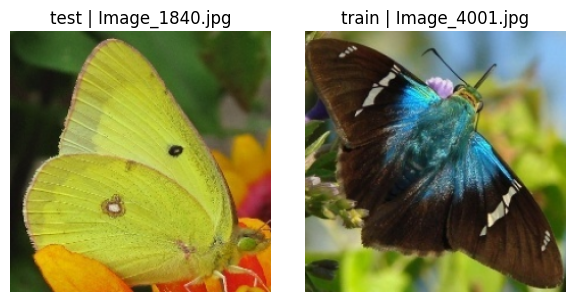

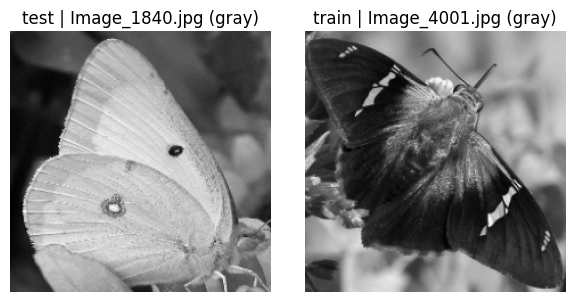

Observation: RGB keeps color patterns on butterfly wings; gray drops hue but preserves texture/edges.


In [4]:
demo_imgs_rgb = []
demo_titles   = []
for p in sample_paths[:6]:  # show a few
    img = imread_color(p)
    demo_imgs_rgb.append(resize_keep(img))
    demo_titles.append(f"{Path(p).parent.name} | {Path(p).name}")

show_images(demo_imgs_rgb, demo_titles, cols=3, scale=3)

# Show grayscale versions
demo_imgs_gray = [to_gray(im) for im in demo_imgs_rgb]
show_images(demo_imgs_gray, [t+" (gray)" for t in demo_titles], cols=3, scale=3)
print("Observation: RGB keeps color patterns on butterfly wings; gray drops hue but preserves texture/edges.")


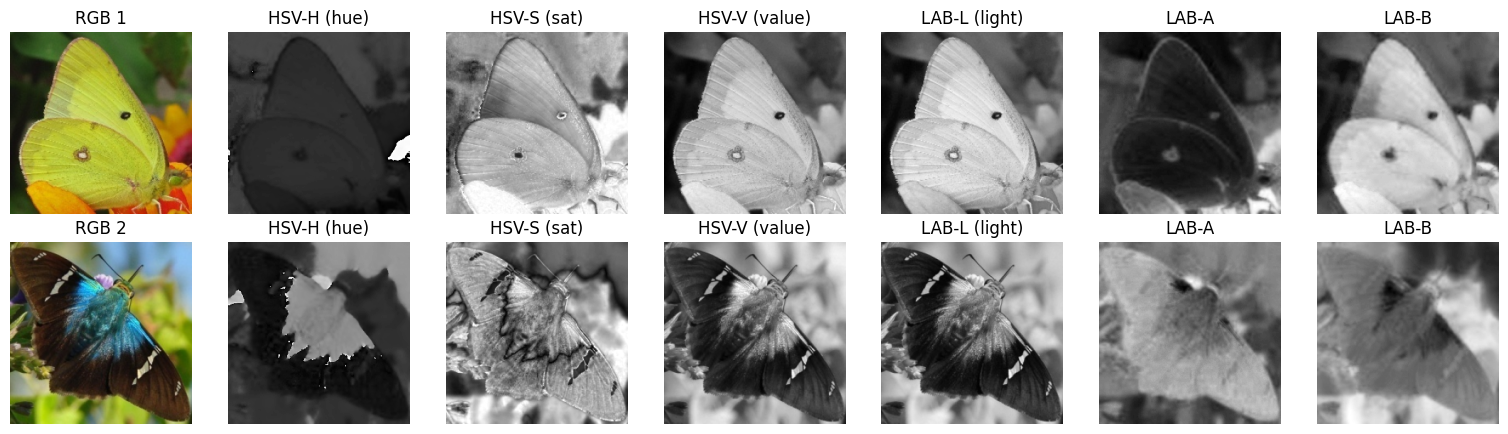

Takeaway: Hue (H) isolates color type; Saturation (S) captures intensity of color; Value (V) is brightness.
LAB-L is lightness; A/B carry opponent color info—useful for illumination-robust preprocessing.


In [5]:
imgs = demo_imgs_rgb[:4]
panels = []
titles = []

for i, rgb in enumerate(imgs):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    panels.extend([rgb, hsv[...,0], hsv[...,1], hsv[...,2], lab[...,0], lab[...,1], lab[...,2]])
    titles.extend([
        f"RGB {i+1}",
        "HSV-H (hue)", "HSV-S (sat)", "HSV-V (value)",
        "LAB-L (light)", "LAB-A", "LAB-B"
    ])

show_images(panels, titles, cols=7, scale=2.2)
print(
    "Takeaway: Hue (H) isolates color type; Saturation (S) captures intensity of color; Value (V) is brightness.\n"
    "LAB-L is lightness; A/B carry opponent color info—useful for illumination-robust preprocessing."
)


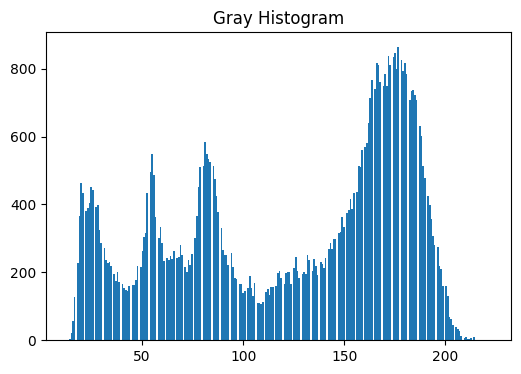

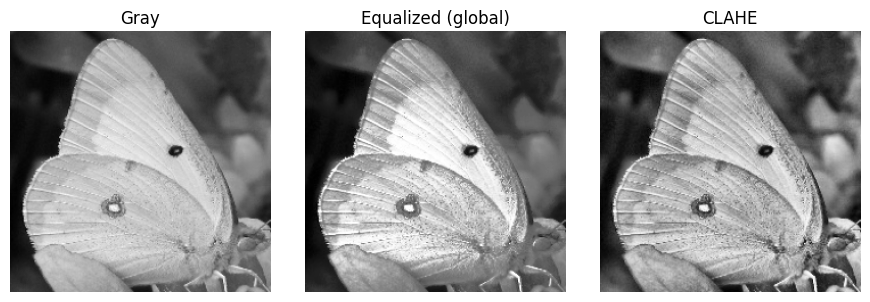

Observation: Equalization boosts global contrast; CLAHE improves local contrast (wing patterns) without over-amplifying noise.


In [6]:
rgb = demo_imgs_rgb[0]
gray = to_gray(rgb)

# Histograms
plt.figure(figsize=(6,4)); plt.hist(gray.ravel(), bins=256); plt.title("Gray Histogram"); plt.show()

# Global histogram equalization
eq = cv2.equalizeHist(gray)

# CLAHE (adaptive)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cla = clahe.apply(gray)

show_images([gray, eq, cla], ["Gray", "Equalized (global)", "CLAHE"], cols=3, scale=3)
print("Observation: Equalization boosts global contrast; CLAHE improves local contrast (wing patterns) without over-amplifying noise.")


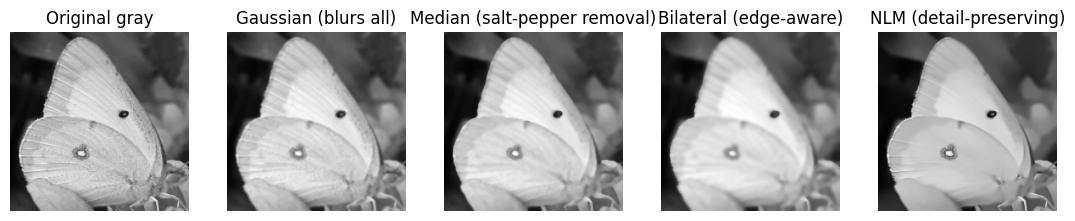

Note: Bilateral/NLM keep edges while reducing noise—handy before edge/contour detection.


In [7]:
gray = to_gray(demo_imgs_rgb[0])

gauss = cv2.GaussianBlur(gray, (5,5), 1.0)
median = cv2.medianBlur(gray, 5)
bilat = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)

# Non-Local Means (OpenCV fastNlMeansDenoising)
nlm = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)

show_images([gray, gauss, median, bilat, nlm],
            ["Original gray", "Gaussian (blurs all)", "Median (salt-pepper removal)", "Bilateral (edge-aware)", "NLM (detail-preserving)"],
            cols=5, scale=2.2)
print("Note: Bilateral/NLM keep edges while reducing noise—handy before edge/contour detection.")


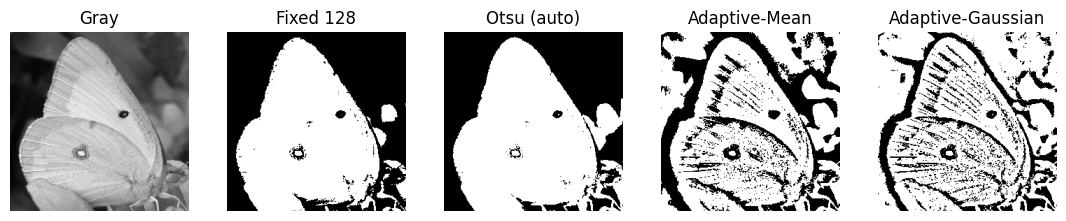

Interpretation: Otsu picks a single best split; Adaptive varies per region—useful if illumination varies on the butterfly or background.


In [8]:
gray = to_gray(demo_imgs_rgb[0])

# Global fixed threshold
_, th_fixed = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

# Otsu (auto global threshold)
_, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Adaptive (handles uneven lighting)
th_ad_mean = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY, blockSize=35, C=5)
th_ad_gaus = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, blockSize=35, C=5)

show_images([gray, th_fixed, th_otsu, th_ad_mean, th_ad_gaus],
            ["Gray", "Fixed 128", "Otsu (auto)", "Adaptive-Mean", "Adaptive-Gaussian"], cols=5, scale=2.2)
print("Interpretation: Otsu picks a single best split; Adaptive varies per region—useful if illumination varies on the butterfly or background.")


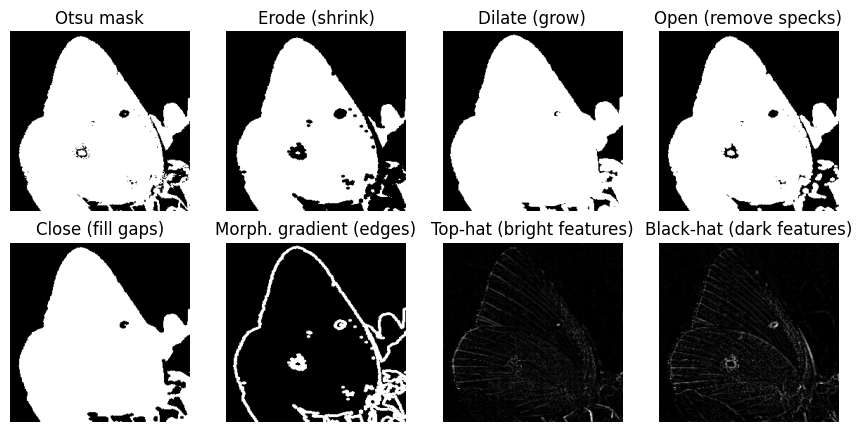

Use open to remove small noise; close to fill small holes in wings; gradient approximates edges; top/black-hat enhance local contrast features.


In [9]:
gray = to_gray(demo_imgs_rgb[0])
_, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

erode  = cv2.erode(th, kernel, iterations=1)
dilate = cv2.dilate(th, kernel, iterations=1)
open_  = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
close  = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)
grad   = cv2.morphologyEx(th, cv2.MORPH_GRADIENT, kernel)
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

show_images([th, erode, dilate, open_, close, grad, tophat, blackhat],
            ["Otsu mask", "Erode (shrink)", "Dilate (grow)", "Open (remove specks)", "Close (fill gaps)",
             "Morph. gradient (edges)", "Top-hat (bright features)", "Black-hat (dark features)"],
            cols=4, scale=2.2)
print("Use open to remove small noise; close to fill small holes in wings; gradient approximates edges; top/black-hat enhance local contrast features.")


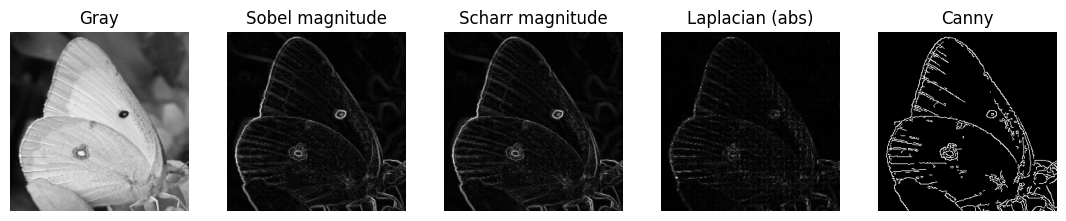

Canny gives thin, clean edges (sensitive to thresholds). Sobel/Scharr provide gradient magnitude; Scharr is better for small kernels.


In [10]:
gray = to_gray(demo_imgs_rgb[0])

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)
scharrx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
scharry = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
scharr = cv2.magnitude(scharrx, scharry)
lap = cv2.Laplacian(gray, cv2.CV_64F, ksize=3)
canny = cv2.Canny(gray, 80, 160)  # tune thresholds per image

show_images([gray, sobel, scharr, np.abs(lap), canny],
            ["Gray", "Sobel magnitude", "Scharr magnitude", "Laplacian (abs)", "Canny"], cols=5, scale=2.2)
print("Canny gives thin, clean edges (sensitive to thresholds). Sobel/Scharr provide gradient magnitude; Scharr is better for small kernels.")


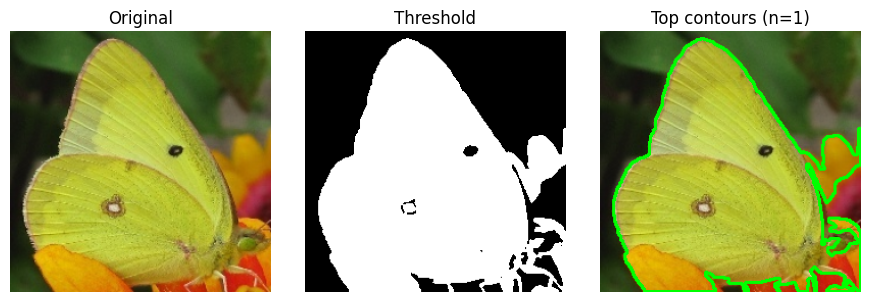

Found 1 contours; top 5 areas: [38578.5]
Use area filtering to isolate the butterfly silhouette (largest contour) vs background specks.


In [11]:
rgb = demo_imgs_rgb[0]
gray = to_gray(rgb)

# Preprocess: blur + Otsu for stable contours
blur = cv2.GaussianBlur(gray, (5,5), 0)
_, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

cnts, hier = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

overlay = rgb.copy()
cv2.drawContours(overlay, cnts[:10], -1, (0,255,0), 2)

areas = [cv2.contourArea(c) for c in cnts]
show_images([rgb, th, overlay], ["Original", "Threshold", f"Top contours (n={min(10,len(cnts))})"], cols=3, scale=3)
print(f"Found {len(cnts)} contours; top 5 areas:", areas[:5])
print("Use area filtering to isolate the butterfly silhouette (largest contour) vs background specks.")


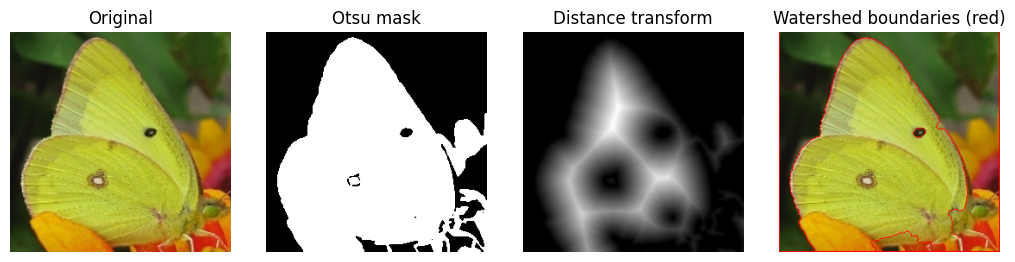

Watershed uses seeds from distance transform to separate touching regions and refine the butterfly boundary.


In [12]:
rgb = demo_imgs_rgb[0]
gray = to_gray(rgb)

# Binary mask
_, th = cv2.threshold(cv2.GaussianBlur(gray, (5,5), 0), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Morphological cleanup
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background and sure foreground
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist, 0.5*dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Markers
num_labels, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0

# Watershed expects BGR
bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
markers = cv2.watershed(bgr, markers)
seg = rgb.copy()
seg[markers == -1] = [255, 0, 0]  # boundaries in red

show_images([rgb, th, dist, seg],
            ["Original", "Otsu mask", "Distance transform", "Watershed boundaries (red)"], cols=4, scale=2.6)
print("Watershed uses seeds from distance transform to separate touching regions and refine the butterfly boundary.")


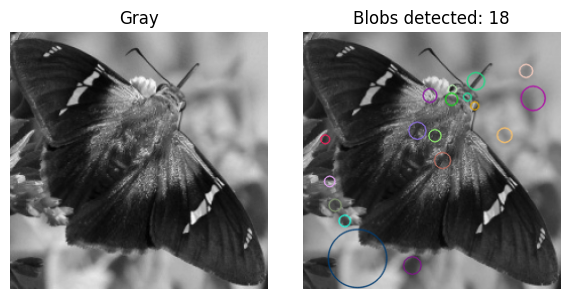

Blobs can capture wing spots/patterns that are distinctive across species.


In [13]:
gray = to_gray(demo_imgs_rgb[1] if len(demo_imgs_rgb)>1 else demo_imgs_rgb[0])

params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 30
params.maxArea = 5000
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(gray)

overlay = cv2.drawKeypoints(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB),
                            keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

show_images([gray, overlay], ["Gray", f"Blobs detected: {len(keypoints)}"], cols=2, scale=3)
print("Blobs can capture wing spots/patterns that are distinctive across species.")


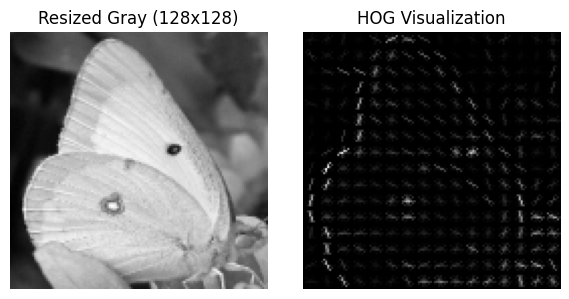

HOG summarizes edge orientations—useful as a classic feature for SVM classifiers.
HOG feature length: (8100,)


In [14]:
rgb = demo_imgs_rgb[0]
gray = to_gray(rgb)
gray_res = resize_keep(gray, (128,128))

hog_vec, hog_img = feature.hog(
    gray_res, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2),
    visualize=True, block_norm="L2-Hys"
)

show_images([gray_res, hog_img], ["Resized Gray (128x128)", "HOG Visualization"], cols=2, scale=3)
print("HOG summarizes edge orientations—useful as a classic feature for SVM classifiers.")
print("HOG feature length:", hog_vec.shape)


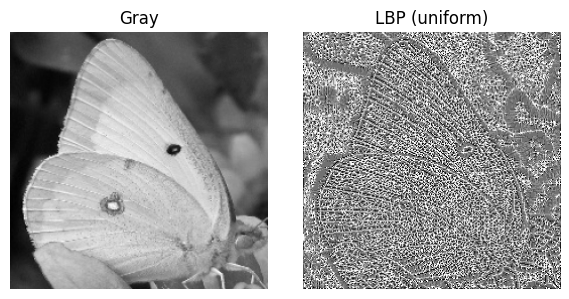

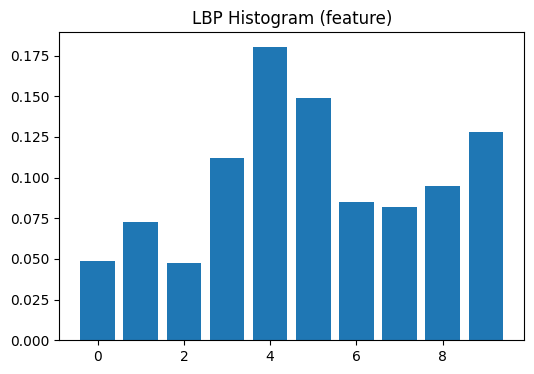

LBP captures micro-texture—butterfly scales and patterns—robust to illumination changes.


In [15]:
from skimage.feature import local_binary_pattern

gray = to_gray(demo_imgs_rgb[0])
gray_res = resize_keep(gray, (256,256))

# LBP parameters: P points on a circle of radius R
P, R = 8, 1
lbp = local_binary_pattern(gray_res, P=P, R=R, method="uniform")

# Histogram of LBP (as feature vector)
(n, bins) = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2), density=True)

show_images([gray_res, lbp], ["Gray", "LBP (uniform)"], cols=2, scale=3)
plt.figure(); plt.bar(range(len(n)), n); plt.title("LBP Histogram (feature)"); plt.show()
print("LBP captures micro-texture—butterfly scales and patterns—robust to illumination changes.")


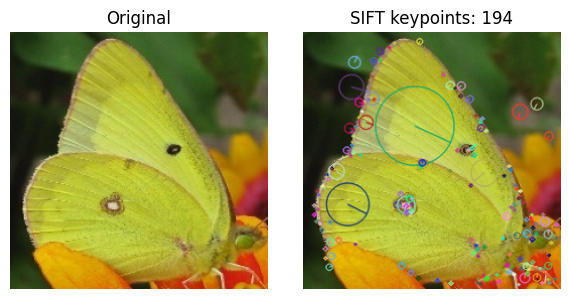

Descriptors shape: (194, 128)
SIFT finds scale/rotation-invariant keypoints—great for matching or classic pipelines.


In [16]:
rgb = demo_imgs_rgb[0]
gray = to_gray(rgb)

sift = None
try:
    # OpenCV >=4.4: SIFT built-in
    sift = cv2.SIFT_create()
except Exception as e:
    pass

if sift is None:
    print("SIFT not available in this environment. Skipping.")
else:
    kps, desc = sift.detectAndCompute(gray, None)
    out = cv2.drawKeypoints(rgb, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    show_images([rgb, out], ["Original", f"SIFT keypoints: {len(kps)}"], cols=2, scale=3)
    print("Descriptors shape:", None if desc is None else desc.shape)
    print("SIFT finds scale/rotation-invariant keypoints—great for matching or classic pipelines.")
